# Bigmart Sales Prediction

- 회귀 모델로 분석하기

### 필요한 패키지 임포트 하기

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 불러오기

In [3]:
df = pd.read_csv('Train.csv', sep=',')
df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


##### - 결측치 처리

In [4]:
df.shape

(8523, 12)

In [5]:
# 결측치 확인 -> 결측치 많은 편 아니므로 대체할 값 선정
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- Item_Weight 결측치 -> 평균 무게로 대체

In [6]:
# Item_Weight의 평균값 결측치에 삽입하기
df.Item_Weight.fillna(df.Item_Weight.mean(), inplace=True)
# 변경 후 결측값 확인
df.Item_Weight.isna().sum()

0

- Outlet_Size -> 최빈값 데이터로 대체

In [7]:
# Outlet_Size 컬럼 데이터 별 개수 세기
df.Outlet_Size.value_counts() # 최빈값 : High 
df.Outlet_Size.fillna('High', inplace=True)

In [8]:
# 전체 결측치 다시 확인하기
df.isna().sum().sum()

0

##### - 카테고리 값인 컬럼 숫자로 변환

- 카테고리 값인 컬럼
    - Item_Fat_Content / Item_Type / Outlet_Size / Outlet_Location_Type / Outlet_Type

##### 1. 카테고리 값인 컬럼 데이터 종류 분석해서 일정하게 맞추기

In [9]:
df.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [10]:
# Low Fat == low fat, LF / Regular == reg 
df['Item_Fat_Content'].replace(['low fat', 'LF', 'reg'], ['Low Fat', 'Low Fat', 'Regular'], inplace=True)
# 데이터 변경 적용되었는지 확인
df.Item_Fat_Content.value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

##### 2. 카테고리 값인 컬럼 인코딩 하기

In [11]:
# Label Encoder 로 변환 -> 객체 생성
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [12]:
# 데이터 인코딩
df.Item_Fat_Content = le.fit_transform(df.Item_Fat_Content)
df.Item_Type = le.fit_transform(df.Item_Type)
df.Outlet_Size = le.fit_transform(df.Outlet_Size)
df.Outlet_Location_Type = le.fit_transform(df.Outlet_Location_Type)
df.Outlet_Type = le.fit_transform(df.Outlet_Type)
df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,0,0.016047,4,249.8092,OUT049,1999,1,0,1,3735.1380
1,DRC01,5.92,1,0.019278,14,48.2692,OUT018,2009,1,2,2,443.4228
2,FDN15,17.50,0,0.016760,10,141.6180,OUT049,1999,1,0,1,2097.2700


In [34]:
# 인코딩 상태 확인하기
print(np.unique(df.Item_Fat_Content, return_counts=True)) # Low Fat(0) / Regular(1)
print(np.unique(df.Item_Type, return_counts=True))
print(np.unique(df.Outlet_Size, return_counts=True)) # High(0) / Medium(1) / Small(2)
print(np.unique(df.Outlet_Location_Type, return_counts=True)) # Tier 3(0) / Tier 2(1) / Tier1(2)
print(np.unique(df.Outlet_Type, return_counts=True)) # Grocery Store(0) / Supermarket Type1(1) / Supermarket Type2(2) / Supermarket Type3(3)

(array([0, 1]), array([5517, 3006], dtype=int64))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([ 648,  251,  110,  649,  682,  856, 1232,  214,  520,  910,  425,
        169,   64, 1200,  445,  148], dtype=int64))
(array([0, 1, 2]), array([3342, 2793, 2388], dtype=int64))
(array([0, 1, 2]), array([2388, 2785, 3350], dtype=int64))
(array([0, 1, 2, 3]), array([1083, 5577,  928,  935], dtype=int64))


##### 3. 컬럼 (Outlet_Establishment_Year -> Outlet_Age) 조작하기

- 아울렛이 얼마나 오래되었는지 나타내는 컬럼으로 바꾸기

In [14]:
df['Outlet_Establishment_Year'] = df.Outlet_Establishment_Year.apply(lambda year : 2021 - year)

In [15]:
df.rename(columns={'Outlet_Establishment_Year': 'Outlet_Age'}, inplace=True)
df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Age,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,0,0.016047,4,249.8092,OUT049,22,1,0,1,3735.1380
1,DRC01,5.92,1,0.019278,14,48.2692,OUT018,12,1,2,2,443.4228
2,FDN15,17.50,0,0.016760,10,141.6180,OUT049,22,1,0,1,2097.2700


- 전체 데이터 시각화

In [16]:
# 필요한 컬럼만 들고오기
df.drop(columns=['Item_Identifier','Outlet_Identifier'], inplace=True)
df.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Age,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,0,0.016047,4,249.8092,22,1,0,1,3735.1380
1,5.92,1,0.019278,14,48.2692,12,1,2,2,443.4228
2,17.50,0,0.016760,10,141.6180,22,1,0,1,2097.2700


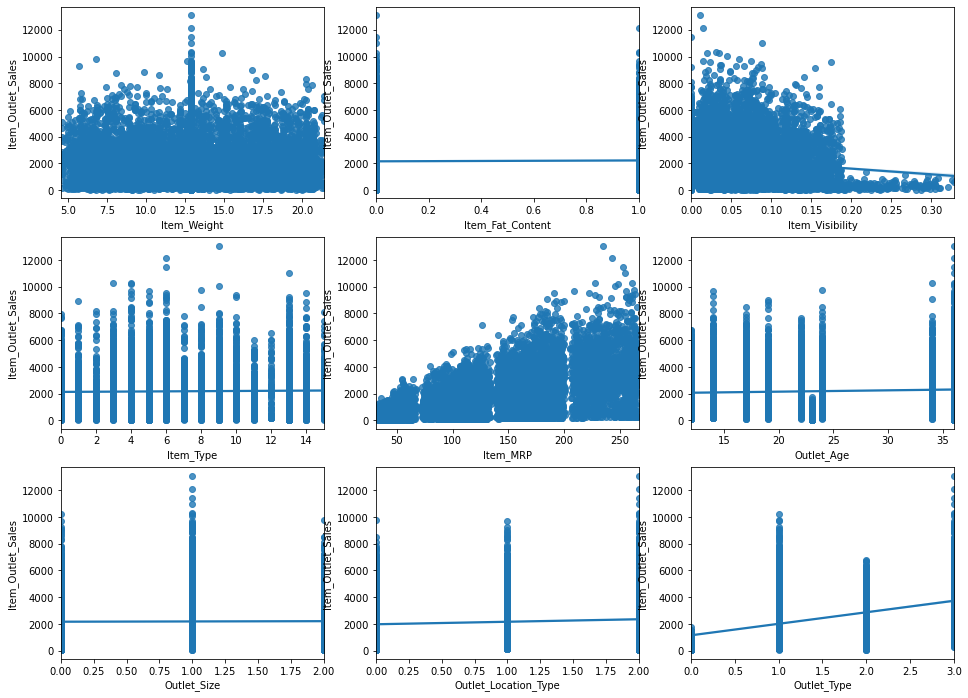

In [18]:
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(16,12))           
for i, feature in enumerate(df.columns[:-1]):                     
    row, col = i//3, i%3                                            
    sns.regplot(x=feature, y='Item_Outlet_Sales', data=df, ax=axs[row][col])

### 회귀선 그리기

##### 주제1. Item_Visibility vs. Item_Outlet_Sales

- 상품의 디스플레이 비중에 따른 매출액 추이

In [19]:
item_visibility = df.Item_Visibility.values.reshape(-1,1)    # X 값
sales_amount = df.Item_Outlet_Sales.values   # target(label) 값
item_visibility.shape, sales_amount.shape

((8523, 1), (8523,))

In [20]:
# 학습 / 테스트 데이터셋 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    item_visibility, sales_amount, test_size=0.1, random_state=2021
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7670, 1), (853, 1), (7670,), (853,))

In [21]:
# 학습 데이터로 훈련 및 예측
from sklearn.linear_model import LinearRegression   # 단순선형회귀
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.016302341439267676

- 시각화

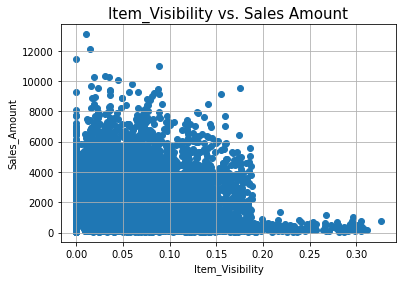

In [22]:
# 산점도 시각화
plt.scatter(X_train, y_train)
plt.grid()
plt.xlabel('Item_Visibility')
plt.ylabel('Sales_Amount')
plt.title('Item_Visibility vs. Sales Amount', fontsize=15)
plt.show()

- 회귀선 구하기

In [23]:
# 회귀선의 계수 / 절편
lr.coef_, lr.intercept_

(array([-4258.3142543]), 2459.823415395422)

In [24]:
# 회귀선 식 구하기
xs = np.array([0, 0.34])    # x값 = 독립변수
ys = xs * lr.coef_ + lr.intercept_ # lr.coef_ : weight / lr.intercept_ : bias
ys

array([2459.8234154 , 1011.99656893])

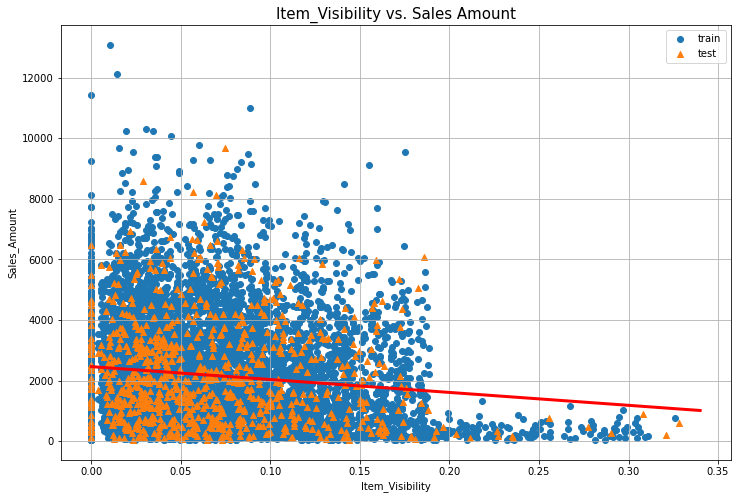

In [25]:
# 산점도 + 회귀선
plt.figure(figsize=(12,8))
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, marker='^', label='test')
plt.plot(xs, ys, 'r-', lw=3)
plt.grid()
plt.xlabel('Item_Visibility')
plt.ylabel('Sales_Amount')
plt.title('Item_Visibility vs. Sales Amount', fontsize=15)
plt.legend()
plt.show()

##### 주제2. Item_MRP vs. Item_Outlet_Sales

- 상품의 최대 가격에 따른 매출액 추이

In [26]:
item_mrp = df.Item_MRP.values.reshape(-1,1)    # X 값
sales_amount = df.Item_Outlet_Sales.values   # target(label) 값
item_mrp.shape, sales_amount.shape

((8523, 1), (8523,))

In [29]:
# 학습 / 테스트 데이터셋 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    item_mrp, sales_amount, test_size=0.1, random_state=2021
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7670, 1), (853, 1), (7670,), (853,))

In [28]:
# 학습 데이터로 훈련 및 예측
from sklearn.linear_model import LinearRegression   # 단순선형회귀
lr2 = LinearRegression()
lr2.fit(X_train, y_train)
lr2.score(X_test, y_test)

0.3577367806660219

- 시각화

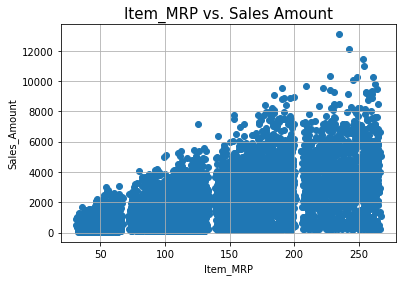

In [30]:
# 산점도 시각화
plt.scatter(X_train, y_train)
plt.grid()
plt.xlabel('Item_MRP')
plt.ylabel('Sales_Amount')
plt.title('Item_MRP vs. Sales Amount', fontsize=15)
plt.show()

- 회귀선 구하기

In [31]:
# 계수 / 절편
lr2.coef_, lr2.intercept_

(array([15.48478217]), -4.672751774833159)

In [32]:
xs2 = np.array([20, 270])
ys2 = xs2 * lr2.coef_ + lr2.intercept_
ys2

array([ 305.02289157, 4176.21843342])

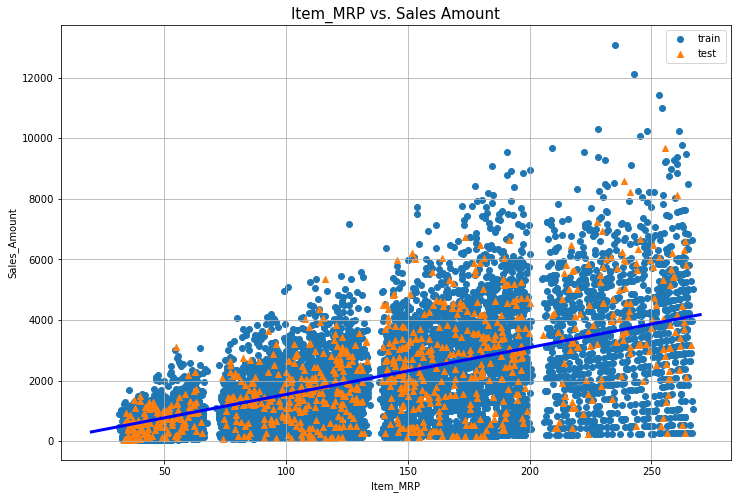

In [33]:
# 산점도 + 회귀선
plt.figure(figsize=(12,8))
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, marker='^', label='test')
plt.plot(xs2, ys2, 'b-', lw=3)
plt.grid()
plt.xlabel('Item_MRP')
plt.ylabel('Sales_Amount')
plt.title('Item_MRP vs. Sales Amount', fontsize=15)
plt.legend()
plt.show()

### 결론

##### 주제1. 상품의 디스플레이 비중에 따른 매출액 추이

- 매장 내 진열 비중이 높은 상품이 반드시 높은 매출을 발생시키는 것은 아니다.
    - 음의 상관관계

##### 주제2. 상품의 최대 가격에 따른 매출액 추이

- 최대 가격(정가)이 높은 상품일수록 매출액이 증가하는 경향이 있다.
    - 양의 상관관계

##### 결과

- 상품의 디스플레이 비중보다 상품의 최대 가격이 매출액을 증가시키는 주요 요인이다.
    - 가격이 높은 상품은 그렇지 않은 상품보다 적게 팔려도 기본 단가가 높기 때문에 '매출액'을 기준으로 분석했을 때 보다 높은 매출을 기록할 가능성이 크기 때문이다.